<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/MLT-x-fastai/blob/master/mini-lessons/fastai_text_data_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

Content from this notebook has been inspired from the fast.ai course-v3 Part 1. In this notebook we'll go through some standard NLP tasks using lessons from fast.ai. We will learn about Transfer Learning in NLP, creating `TextDataBunch` objects, training a model for text classification task and a Sequence2Sequence task We will see how the `fastai` library uses a style called the Data Block API to simplify the process of prepping data for different tasks.

In [0]:
#Google Colab notes: imports for uploading files
#from google.colab import files

In [0]:
#Google Colab notes: make data directory
#!mkdir data

In [3]:
path = Path('data')

## Language Modeling

One of the most common tasks done in NLP is called language modeling. A language model is an NLP model which learns to predict the next word in a sentence. We do this is because we assume that if a language model is quite accurate at guessing the next probable word in a sentnce, it needs a lot of world knowledge and a deep understanding of grammar, semantics, and other elements of natural language.

We will show how to train a simple language model.

In [3]:
#!wget https://s3.amazonaws.com/text-datasets/nietzsche.txt
#!mv nietzsche.txt data

In [7]:
df = pd.DataFrame(open(path/'nietzsche.txt').read().split('\n\n'))
df.head()

,0
0,PREFACE
1,\nSUPPOSING that Truth is a woman--what then? ...
2,"Sils Maria Upper Engadine, JUNE, 1885."
3,
4,\nCHAPTER I. PREJUDICES OF PHILOSOPHERS


In [0]:
bs=64
data_lm = (TextList.from_df(df,path,cols=[0])
                   .split_by_rand_pct(0.1)
                   .label_for_lm()
                   .databunch(bs=bs))

In [9]:
data_lm.show_batch()

idx,text
0,"unseemly methods for \n xxunk a woman ? xxmaj certainly she has never allowed herself to be won ; and \n at present every kind of dogma stands with sad and xxunk xxunk -- xxup if , \n indeed , it stands at all ! xxmaj for there are xxunk who maintain that it \n has fallen , that all dogma lies on the ground --"
1,"an opinion is life - xxunk , life - preserving , \n species - preserving , perhaps species - rearing , and we are fundamentally \n inclined to maintain that the xxunk opinions ( to which the synthetic \n judgments a priori belong ) , are the most indispensable to us , that \n without a recognition of logical fictions , without a comparison of \n"
2,", the \n will to "" creation of the world , "" the will to the causa xxunk . xxbos 10 . xxmaj the eagerness and subtlety , i should even say craftiness , with \n which the problem of "" the real and the apparent world "" is xxunk with at \n present throughout xxmaj europe , furnishes food for thought and attention ; and \n"
3,"belief ought to be xxunk from science ! xxmaj between \n ourselves , it is not at all necessary to get rid of "" the soul "" thereby , \n and thus renounce one of the oldest and most xxunk hypotheses -- as \n happens frequently to the clumsiness of xxunk , who can hardly \n touch on the soul without immediately losing it . xxmaj"
4,"alone is really known to us , absolutely and \n completely known , without deduction or addition . xxmaj but it again and \n again seems to me that in this case xxmaj schopenhauer also only did what \n philosophers are in the habit of doing -- he seems to have adopted a \n xxup popular xxup prejudice and exaggerated it . xxmaj willing seems to"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM,drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


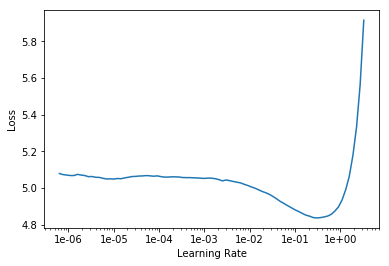

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1,1e-2,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.749605,4.329587,0.213988,00:09


In [13]:
learn.unfreeze()
learn.fit_one_cycle(4,3e-3,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.242284,3.997777,0.256920,00:11
1,4.024162,3.899869,0.265625,00:11
2,3.843143,3.868506,0.266295,00:11
3,3.600221,3.874033,0.270610,00:11


In [14]:
learn.predict('It is perhaps just dawning on five or six minds',n_words=100)

'It is perhaps just dawning on five or six minds . Yet the most extensive fact of the \n  circumstances has been been provided after the accident of More \n  and Bell of Saint fire in whose grace and hatred of \n  period talk represents their goal : where the populace has grown \n  and there is well enough with regard to the HIGHER \n  world of the present school , in whom a number could not , step home , be learnt \n  to live as maid and lover and of distinction : \n  hitherto , of course , in speaking hours and habits'

## Tokenization and Numericalization
The most common preprocessing on NLP tasks in tokenization i.e splitting the sentence into words. This is much easier in space-seperated words like English however, for Japanese we require Morphological Analysis tools to get words from sentences.

Numericalizing in the second preprocessing step. Since models can only take numbers as inputs, we make a dictionary mapping unique words to indices and replace the words with the words in the sentence with their corresponding index. Here we limit our dictionary size to 60000 words that appear at least twice in our corpus.

In [0]:
#Google Colab notes: install dependencies for mecab tokenizer
#!sudo apt install swig
#!sudo apt install mecab
#!sudo apt install libmecab-dev
#!sudo apt install mecab-ipadic-utf8
#!sudo pip3 install mecab-python3

In [4]:
import re
import MeCab

tagger = MeCab.Tagger("-Owakati")

class MeCabTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = 'ja'
    
    def add_special_cases(self, toks:Collection[str]): pass
    
    def tokenizer(self,raw_sentence):
        result = tagger.parse(raw_sentence)
        words = result.split()
        if len(words) == 0:
            return []
        if words[-1] == "\n":
            words = words[:-1]
        return words

In [5]:
tokenizer = Tokenizer(MeCabTokenizer, 'ja')
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=60000,min_freq=2)]

## Text Classification
One particular area that was challenging until recently with deep learning for NLP, was text classification.

Similar to classifying images in text we can also use transfer learning to train accurate classifiers with few training examples. We will leverage weights from a language model trained on a large corpus as our pretrained weights. We will fine-tune the language model to our target dataset, attach a classification layer to our model and train by gradual unfreezing. The text classifying task will be sentiment analysis on Yahoo Movie Reviews. The data can be downloaded from this [repository](https://github.com/dennybritz/sentiment-analysis/tree/master/data)

In [6]:
#Google Colab Notes: download data and upload them into your notebook environment
#files.upload()

In [7]:
#Google Colab Notes: uncompress data and move to data directory
#!tar xvzf yahoo-movie-reviews.json.tar.gz


In [8]:
def load_ymr_data(path):
    with path.open() as f:
        data = pd.read_json(f)
        data.movieName = data.movieName.str.strip()
        data.text = data.text.str.strip()
        data.title = data.title.str.strip()
        data = data[data.text.str.len() > 0]
        data.url = data.url.str.strip()
    return data

def make_polar(data, balance=True):
    data_polar = data.loc[data.rating != 3].copy()
    data_polar.loc[data_polar.rating <= 2, 'rating'] = 0
    data_polar.loc[data_polar.rating >= 4, 'rating'] = 1
    if balance:
        # Subsample - We want the same number of positive and negative examples
        grouped_ratings = data_polar.groupby('rating')
        K = grouped_ratings.rating.count().min()
        indices = itertools.chain(
            *[np.random.choice(v, K, replace=False) for k, v in grouped_ratings.groups.items()])
        data_polar = data_polar.reindex(indices).copy()
    return data_polar


mov_df = load_ymr_data(path/'yahoo-movie-reviews.json')
mov_df_polar = make_polar(mov_df)

In [9]:
#mov_df_polar.head()

In [10]:
bs=64

In [11]:
data_lm = (TextList.from_df(mov_df_polar,path,cols=['text'],processor=processor)
                   .split_by_rand_pct(0.1)
                   .label_for_lm()
                   .databunch(bs=bs))

In [12]:
data_lm.show_batch()

idx,text
0,とか 、 好き か 嫌い か という 以前 に 、 映画 の 質 そのもの に 疑問 。 日本映画 史 に 残っ て いく はず の 作品 だけ に … … 、 残念 。 とにもかくにも 、 演出 と 脚本 が ひど すぎる 。 言い出し たら 切り が ない ぐらい だ が 、 まずは 、 なんと いう か 、 「 古い 」 。 （ あるいは 、 いわゆる 「 ベタ 」 。 ）
1,感情 移入 する 人 を 選ぶ な～ と 思い ます 。 いい 子 ばかり が 出る 登場人物 は 、 盛り上がり に も かけ 、 当時 の 洗濯機 や 台所 まわり の 様子 、 風景 を 見 て 、 「 懐かしい わ～ 」 や 「 あの 頃 は ～」 という こと しか 残ら ない 。 テレビ の 2時間 の 枠 の アニメ で 充分 です 。 まわり の 子ども さん は
2,"に は 「 やめ た 方 が いい ！ 」 と 声 を 大 に し て 言い たい ！ ！ 大人 も 子供 も 楽しめ ない 映画 だ と 、 私 は 思い ます ！ 最後 に 余談 です が 、 「 xxunk 」 で この 映画 を 紹介 し た とき に 、 佐 ○ 木 ｱﾅ が 「 私 は これ を 観 て "" xxup et"
3,の 、 偏見 という の は 多かれ 少なかれ ある と 思い ます 。 自分 達 が 美化 さ れ 過ぎ それ に 、 いくら 不遇 な 過去 へ の 孤独感 、 人 と 上手く コミュニケーション が でき ない もどかし さ が ある と は いえ あんな 形 で 、 聾唖 少女 の 痛み を 演じ させる なんて 。 健常者 より も 、 障害 を 持た れる 方 は 、 ずっと
4,終わり ？ まじ か よ 。 」 「 なに これ ？ こんなに 長い 時間 かけて こんな 終わり ？ 」 って 声 が かなり あり まし た 。 来年 の ４月 に パート ２ が やる よう です が 、 その 頃 に は レンタル で て いる ので 、 今回 は わざわざ お金 だして 見る ほど で も ない です 。 xxbos 直感 で くだらな さ そう な 作品 だ


We will initialize our model with weights from a language model trained on Japanese Wikipedia. You can download them from [here](https://drive.google.com/open?id=1KRUEV_3R-JVhcftvWJ66rwU7e_EZWtxE) and you need to place the files in the `data/models/` directory

In [0]:
#Google colab notes: upload model files
#from google.colab import drive
#drive.mount('/content/drive')
#!cp /content/drive/My\ Drive/ja-wiki-awdlstm-model/ja-wiki-itos.pkl 
#!cp /content/drive/My\ Drive/ja-wiki-awdlstm-model/ja-wiki.pth .

In [0]:
#!mv ja-wiki-itos.pkl data/models
#!mv ja-wiki.pth data/models

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM,pretrained_fnames=['ja-wiki','ja-wiki-itos'])

In [14]:
learn.fit_one_cycle(1,1e-2,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.375677,4.124529,0.292882,04:03


In [15]:
learn.unfreeze()
learn.fit_one_cycle(8,3e-3,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.069916,3.950010,0.312577,04:37
1,3.984557,3.836064,0.324826,04:37
2,3.870781,3.762562,0.333079,04:37
3,3.768262,3.712374,0.338276,04:38
4,3.714551,3.674273,0.342792,04:39
5,3.596981,3.647418,0.346149,04:42
6,3.517474,3.636053,0.347601,04:40
7,3.468837,3.635810,0.347985,04:39


In [16]:
learn.save('ymr')
learn.save_encoder('ymr_enc')

In [17]:
data_clas = (TextList.from_df(mov_df_polar,path,cols=['text'],vocab=data_lm.vocab,processor=processor)
                   .split_by_rand_pct(0.1)
                   .label_from_df(cols=['rating'])
                   .databunch(bs=bs))

In [18]:
data_clas.show_batch()

text,target
xxbos ・ 過去 の 行い と 罪 の 意識 から 強 さ の 裏 で 自分 の 命 を 軽 ん じ て い た 剣心 が 、 師匠 と 剣 を 交える うち に 「 死に たく ない ！ 」 「 死ね ない ！ 」 と 強く 思い 、 「 生きよう と する 意思 」 に 目覚め た こと で 本当 の 強 さ を 手 に 入れ 、,0
xxbos 今年 は ジブリ が 輝い て い まし た 。 二 大 巨匠 の 宮崎駿 監督 と 高畑勲 監督 が 、 そろっ て 傑作 を 世に 出し た から でしょ う 。 さて 、 本作 、 物語 の 祖 と も 言わ れる 『 竹取物語 』 を モチーフ と し 、 展開 も ほぼ 原点 に 沿っ た もの と なっ て い ます 。 しかし 、 描か れ,1
xxbos ターゲット の 夢 から 潜在意識 に 侵入 し 、 カタチ に なる 前 の アイデア を 盗み出す こと を 専門 と する 企業 スパイ 、 コブ （ ｌ ･ ディカプリオ ） は 、 業界 で も 屈指 の 凄腕 で ある 。 ある 事件 が 原因 で 最愛 の 妻 を 失い 、 その 殺人容疑 を かけ られ た 彼 は 、 祖国 に 二人 の 子供 を 残し,1
xxbos 私 が 思う ” 理想 的 な 悪人 俳優 ” は ショーン・ビーン と xxunk 、 そして xxunk です 。 という こと で 「 悪人 」 です 。 今作 は 「 パレード 」 で 知ら れる 吉田修一 さん の 原作 を 「 フラガール 」 や 「 69 」 を 手掛け た 李 監督 × 主演 に 妻夫木聡 さん × 音楽 を 久石譲 さん と 豪華 スタッフ ・ キャスト で 映像,1
xxbos 予告 トレーラー を 見 て ワクワク し つつ 、 反面 少し 不安 を 抱え ながら も 鑑賞 。 （ xxup 2d 字幕 ） しかし その 心配 は 杞憂 に 終わっ た ！ 本当に 素晴らしい 映画 だ ！ 新 世代 の 怪獣 xxup sf 映画 と 言える 快 作 （ 怪 作 ） だ 。 巨大 ロボ 「 イェーガー 」 は 無骨 で 重量感 たっぷり 、 まるで 巨大 な 重機,1


In [19]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ymr_enc')

In [20]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.314499,0.251305,0.897328,02:00


In [21]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.271490,0.199659,0.923258,02:14


In [22]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.219154,0.183919,0.928497,03:40


In [23]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.193065,0.181743,0.931116,04:57
1,0.180688,0.182315,0.931378,04:46


In [24]:
learn.save('ymr_clas')

In [25]:
learn.predict("映画すごかったよ!")

(Category 1, tensor(1), tensor([0.0094, 0.9906]))

In [26]:
learn.predict("演技が悪い")

(Category 0, tensor(0), tensor([0.9264, 0.0736]))

## Seq2Seq

A sequence-to-sequence model is a model that takes a sequence of items and outputs another sequence of items using two networks that are trained end-to-end. This is perfect for machine translation since input sequences are directly related to output sequences. We will looking at preparing a dataset for Machine Translation task and implementing a seq2seq model. We will be using the parallel corpus available from [here](ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz)

In [0]:
def make_corpus(corpus_path):
    corpus = corpus_path.open().readlines()
    data_pair = []
    pat = r'#ID.+\n'
    for c in corpus:
        if 'A: ' in c:
            clean_c = c.replace('A: ','')
            res = re.search(pat,clean_c)
            clean_c = clean_c.replace(res.group(0),'').split('\t')
            data_pair.append((clean_c[0],clean_c[1]))
    return pd.DataFrame(data_pair,columns=['ja','en'])

In [0]:
df = make_corpus(path/'examples.utf')
df.head()

,ja,en
0,ムーリエルは２０歳になりました。,Muiriel is 20 now.
1,すぐに戻ります。,I will be back soon.
2,すぐに諦めて昼寝をするかも知れない。,I may give up soon and just nap instead.
3,愛してる。,I love you.
4,ログアウトするんじゃなかったよ。,I shouldn't have logged off.


In [0]:
len(df)

149784

In [0]:
valid_idxs = np.random.choice(np.arange(len(df)), int(0.1*len(df)),replace=False)
train_idxs = [i for i in np.arange(len(df)) if i not in valid_idxs]
len(train_idxs) + len(valid_idxs)

149784

In [0]:
#collation function and databunch code borrowed from here: 
#https://github.com/ohmeow/seq2seq-pytorch-fastai/blob/master/seq2seq-rnn-attn.ipynb

def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        include_targets=True, include_lengths=False, include_masks=False,
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)
    samples.sort(key=lambda x: len(x[0]), reverse=True)
    
    x_lens = [len(s[0]) for s in samples]
    x_max_len = max(x_lens)
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    
    y_lens = [len(s[1]) for s in samples]
    y_max_len = max(y_lens)
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: res = res.flip(1)
        
    x = [x_res]
    if (include_targets): x += [y_res.clone()]
    if (include_lengths): x += [torch.tensor(x_lens), torch.tensor(y_lens)]
    if (include_masks): x += [x_res != pad_idx, y_res != pad_idx]
    
    return x, y_res


class Seq2SeqDataBunch(DataBunch):

    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, 
               path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1, pad_first=False, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        
        """Function that transform the `datasets` in a `DataBunch` for seq2seq task. 
        Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch

In [0]:
en_tok = Tokenizer(lang='en')
en_procs = [TokenizeProcessor(tokenizer=en_tok, include_bos=True, include_eos=True), 
            NumericalizeProcessor(min_freq=1)]

In [0]:
tokenizer = Tokenizer(MeCabTokenizer, 'ja')
ja_procs = [TokenizeProcessor(tokenizer=tokenizer,include_bos=True, include_eos=True), NumericalizeProcessor(max_vocab=30000,min_freq=1)]

In [0]:
en_il = Seq2SeqTextList.from_df(df, path, cols=['en'], processor=en_procs).process().split_by_idxs(train_idxs,valid_idxs)
ja_il = Seq2SeqTextList.from_df(df, path, cols=['ja'], processor=ja_procs).process().split_by_idxs(train_idxs,valid_idxs)

In [0]:
tr_ll = LabelList(en_il.train,ja_il.train)
val_ll = LabelList(en_il.valid,ja_il.valid)
lls = LabelLists(path,train=tr_ll,valid=val_ll)

In [0]:
seq2seq_data = lls.databunch(bs=bs)

In [0]:
seq2seq_data.train_ds[0]

(Text xxbos xxmaj muiriel is 20 now . xxeos,
 Text xxbos ムーリエル は ２ ０ 歳 に なり まし た 。 xxeos)

In [0]:
en_vecs,_,dim_en_vec = load_vectors('data/wiki-news-300d-1M.vec')
j_vecs,_,dim_j_vec = load_vectors('data/cc.ja.300.vec')

In [0]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    if vecs is None: return emb
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w])
        except: miss.append(w)
    print('Number of unknowns in data: {}'.format(len(miss)))
    return emb


In [0]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [0]:
class Seq2SeqAttention(nn.Module):
    def __init__(self,int2en,int2j,em_sz,j_vecs=None,en_vecs=None,nh=128,out_sl=25,dropf=1,nl=2):
        super().__init__()
        #encoder
        self.nl,self.nh,self.em_sz,self.out_sl = nl,nh,em_sz,out_sl
        self.emb_enc = create_emb(en_vecs,int2en,em_sz)
        self.emb_drop = nn.Dropout(0.15*dropf)
        self.encoder = nn.GRU(em_sz,nh,num_layers=nl,dropout=0.25*dropf, bidirectional=True,batch_first=True)
        #decoder
        self.emb_dec = create_emb(j_vecs,int2j,em_sz)
        self.decoder = nn.GRU(em_sz,nh*2,num_layers=nl,dropout=0.25*dropf,batch_first=True)
        self.out_drop = nn.Dropout(0.35*dropf)
        self.out = nn.Linear(nh*2,len(int2j))
        #attention layer
        self.W1 = rand_p(nh*2, nh*2) #parameter
        self.l2 = nn.Linear(nh*2, nh*2)
        self.l3 = nn.Linear(em_sz+nh*2, em_sz)
        self.V = rand_p(nh*2) #parameter
        self.targets = None
    
    def forward(self,inp,y=None):
        self.targets = y
        bs,sl = inp.size()
        emb_in = self.emb_drop(self.emb_enc(inp))
        h_n = self.initHidden(bs)
        enc_out, h_n = self.encoder(emb_in,h_n)
        h_n = h_n.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
        
        dec_inp = torch.zeros(bs).long().cuda()
        res,attns = [], []
        #multiply by parameter
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            #linear layer 
            w2h = self.l2(h_n[-1])
            #non-linear activation to calculate score
            u = torch.tanh(w1e + w2h.unsqueeze(1))
            #softmax to make them into probs
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            #multiply each vector by scores and then add them up
            Xa = (a.unsqueeze(2) * enc_out).sum(1)
            dec_emb = self.emb_dec(dec_inp)
            #linear layer to reduce dimensions
            wgt_enc = self.l3(torch.cat([dec_emb, Xa], 1))
            outp,h_n = self.decoder(wgt_enc.unsqueeze(1),h_n)
            outp = self.out(self.out_drop(outp[:,0]))
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if i >=self.targets.size(1):break
            if (dec_inp==1).all(): break
            if (random.random() > 0.5) and self.targets is not None: dec_inp=y[:,i] 
        return torch.stack(res).transpose(1,0)
        
    def initHidden(self,bs):
        return torch.zeros([self.nl*2,bs,self.nh]).cuda()

In [0]:
def seq2seq_loss(input, target):
    bs,sl = target.size()
    bs_in,sl_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,sl-sl_in,0,0))
    input = input[:,:sl,:]
    return F.cross_entropy(input.contiguous().view(-1,nc), target.contiguous().view(-1))

In [0]:
class TeacherForcingCallback(LearnerCallback):
    learn:Learner
        
    def on_batch_begin(self, train, **kwargs):
        learn.model.targets = kwargs['last_target']

In [0]:
seq2seq = Seq2SeqAttention(seq2seq_data.train_ds.x.vocab.itos,seq2seq_data.train_ds.y.vocab.itos,300,en_vecs=None,j_vecs=None)
seq2seq.cuda()

Seq2SeqAttention(
  (emb_enc): Embedding(21395, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15)
  (encoder): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (emb_dec): Embedding(30004, 300, padding_idx=1)
  (decoder): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=256, out_features=30004, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=556, out_features=300, bias=True)
)

In [0]:
learn = Learner(seq2seq_data,seq2seq)
learn.loss_func = seq2seq_loss

In [0]:
learn.callbacks.append(TeacherForcingCallback(learn))

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


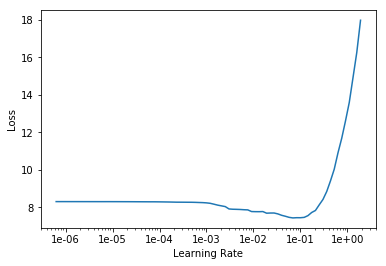

In [0]:
learn.recorder.plot()

In [2]:
learn.fit_one_cycle(5, 3e-3, moms=(0.7,0.8))